In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import math

import logging
from mpytools import Catalog, setup_logging

from clustering_statistics.tools import read_clustering_catalog, select_region

from mpi4py import MPI
mpicomm = MPI.COMM_WORLD

# disable jax warning:
logging.getLogger("jax._src.xla_bridge").setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

setup_logging(level=(logging.INFO if mpicomm.rank == 0 else logging.ERROR))

In [3]:
nside = 64
def make_hpmap(nside,hpix,fill_value=hp.UNSEEN):
    map_ = np.full(12*nside*nside, fill_value=fill_value)
    map_[hpix] = 1
    return map_
    
# def plot_hpmap(nside,ra,dec,mask=None,fill_value=hp.UNSEEN,title=''):
#     # plots wheter or not a pixel is seen based on angular coordinates.
#     # good for checking if regions cuts look correct
#     if mask is not None:
#         ra,dec = ra[mask],dec[mask]
#     hpix_unique = np.unique(hp.ang2pix(nside, ra, dec, nest=False, lonlat=True))
#     hp.mollview(make_hpmap(nside,hpix_unique,fill_value=fill_value),rot=120,title=title)
#     plt.show()

def plot_hpmap(nside, ra, dec, mask=None, fill_value=hp.UNSEEN, title='', ax=None):
    # plots wheter or not a pixel is seen based on angular coordinates.
    # good for checking if regions cuts look correct
    if mask is not None:
        ra, dec = ra[mask], dec[mask]       
    hpix_unique = np.unique(hp.ang2pix(nside, ra, dec, nest=False, lonlat=True))
    if ax is not None:
        plt.sca(ax)
    hp.mollview(make_hpmap(nside, hpix_unique, fill_value=fill_value),
                rot=120,title=title, hold=True, cbar=False)

In [4]:
attrs = {'version': 'holi-v1-altmtl', 'tracer': 'QSO', 'region': 'ALL', 'imock': 201, 'weight': 'default-FKP'}
data = read_clustering_catalog(kind='data', mpicomm=mpicomm, **attrs) 
ra,dec = data['RA'],data['DEC']

[000000.27] [0/1] 02-20 01:38  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl201/loa-v1/mock201/LSScats/QSO_NGC_clustering.dat.h5.
[000000.27] [0/1] 02-20 01:38  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl201/loa-v1/mock201/LSScats/QSO_SGC_clustering.dat.h5.
[000000.37] [0/1] 02-20 01:38  tools                     INFO     Multiplying individual weights by WEIGHT_FKP


[000004.77] [0/1] 02-20 01:38  Footprint                 INFO     Load DR9 footprint with nside=256, mask_lmc=False, clear_south=True, mask_around_des=False and cut_desi=False
[000005.34] [0/1] 02-20 01:38  Footprint                 INFO     Load DR9 footprint with nside=256, mask_lmc=False, clear_south=True, mask_around_des=False and cut_desi=False
[000005.84] [0/1] 02-20 01:38  Footprint                 INFO     Load DR9 footprint with nside=256, mask_lmc=False, clear_south=True, mask_around_des=False and cut_desi=False
[000006.14] [0/1] 02-20 01:38  healpy                    INFO     NSIDE = 4096
[000006.14] [0/1] 02-20 01:38  healpy                    INFO     ORDERING = RING in fits file
[000006.14] [0/1] 02-20 01:38  healpy                    INFO     INDXSCHM = IMPLICIT
[000020.41] [0/1] 02-20 01:39  Footprint                 INFO     Load DR9 footprint with nside=256, mask_lmc=False, clear_south=True, mask_around_des=False and cut_desi=False
[000020.79] [0/1] 02-20 01:39  healp

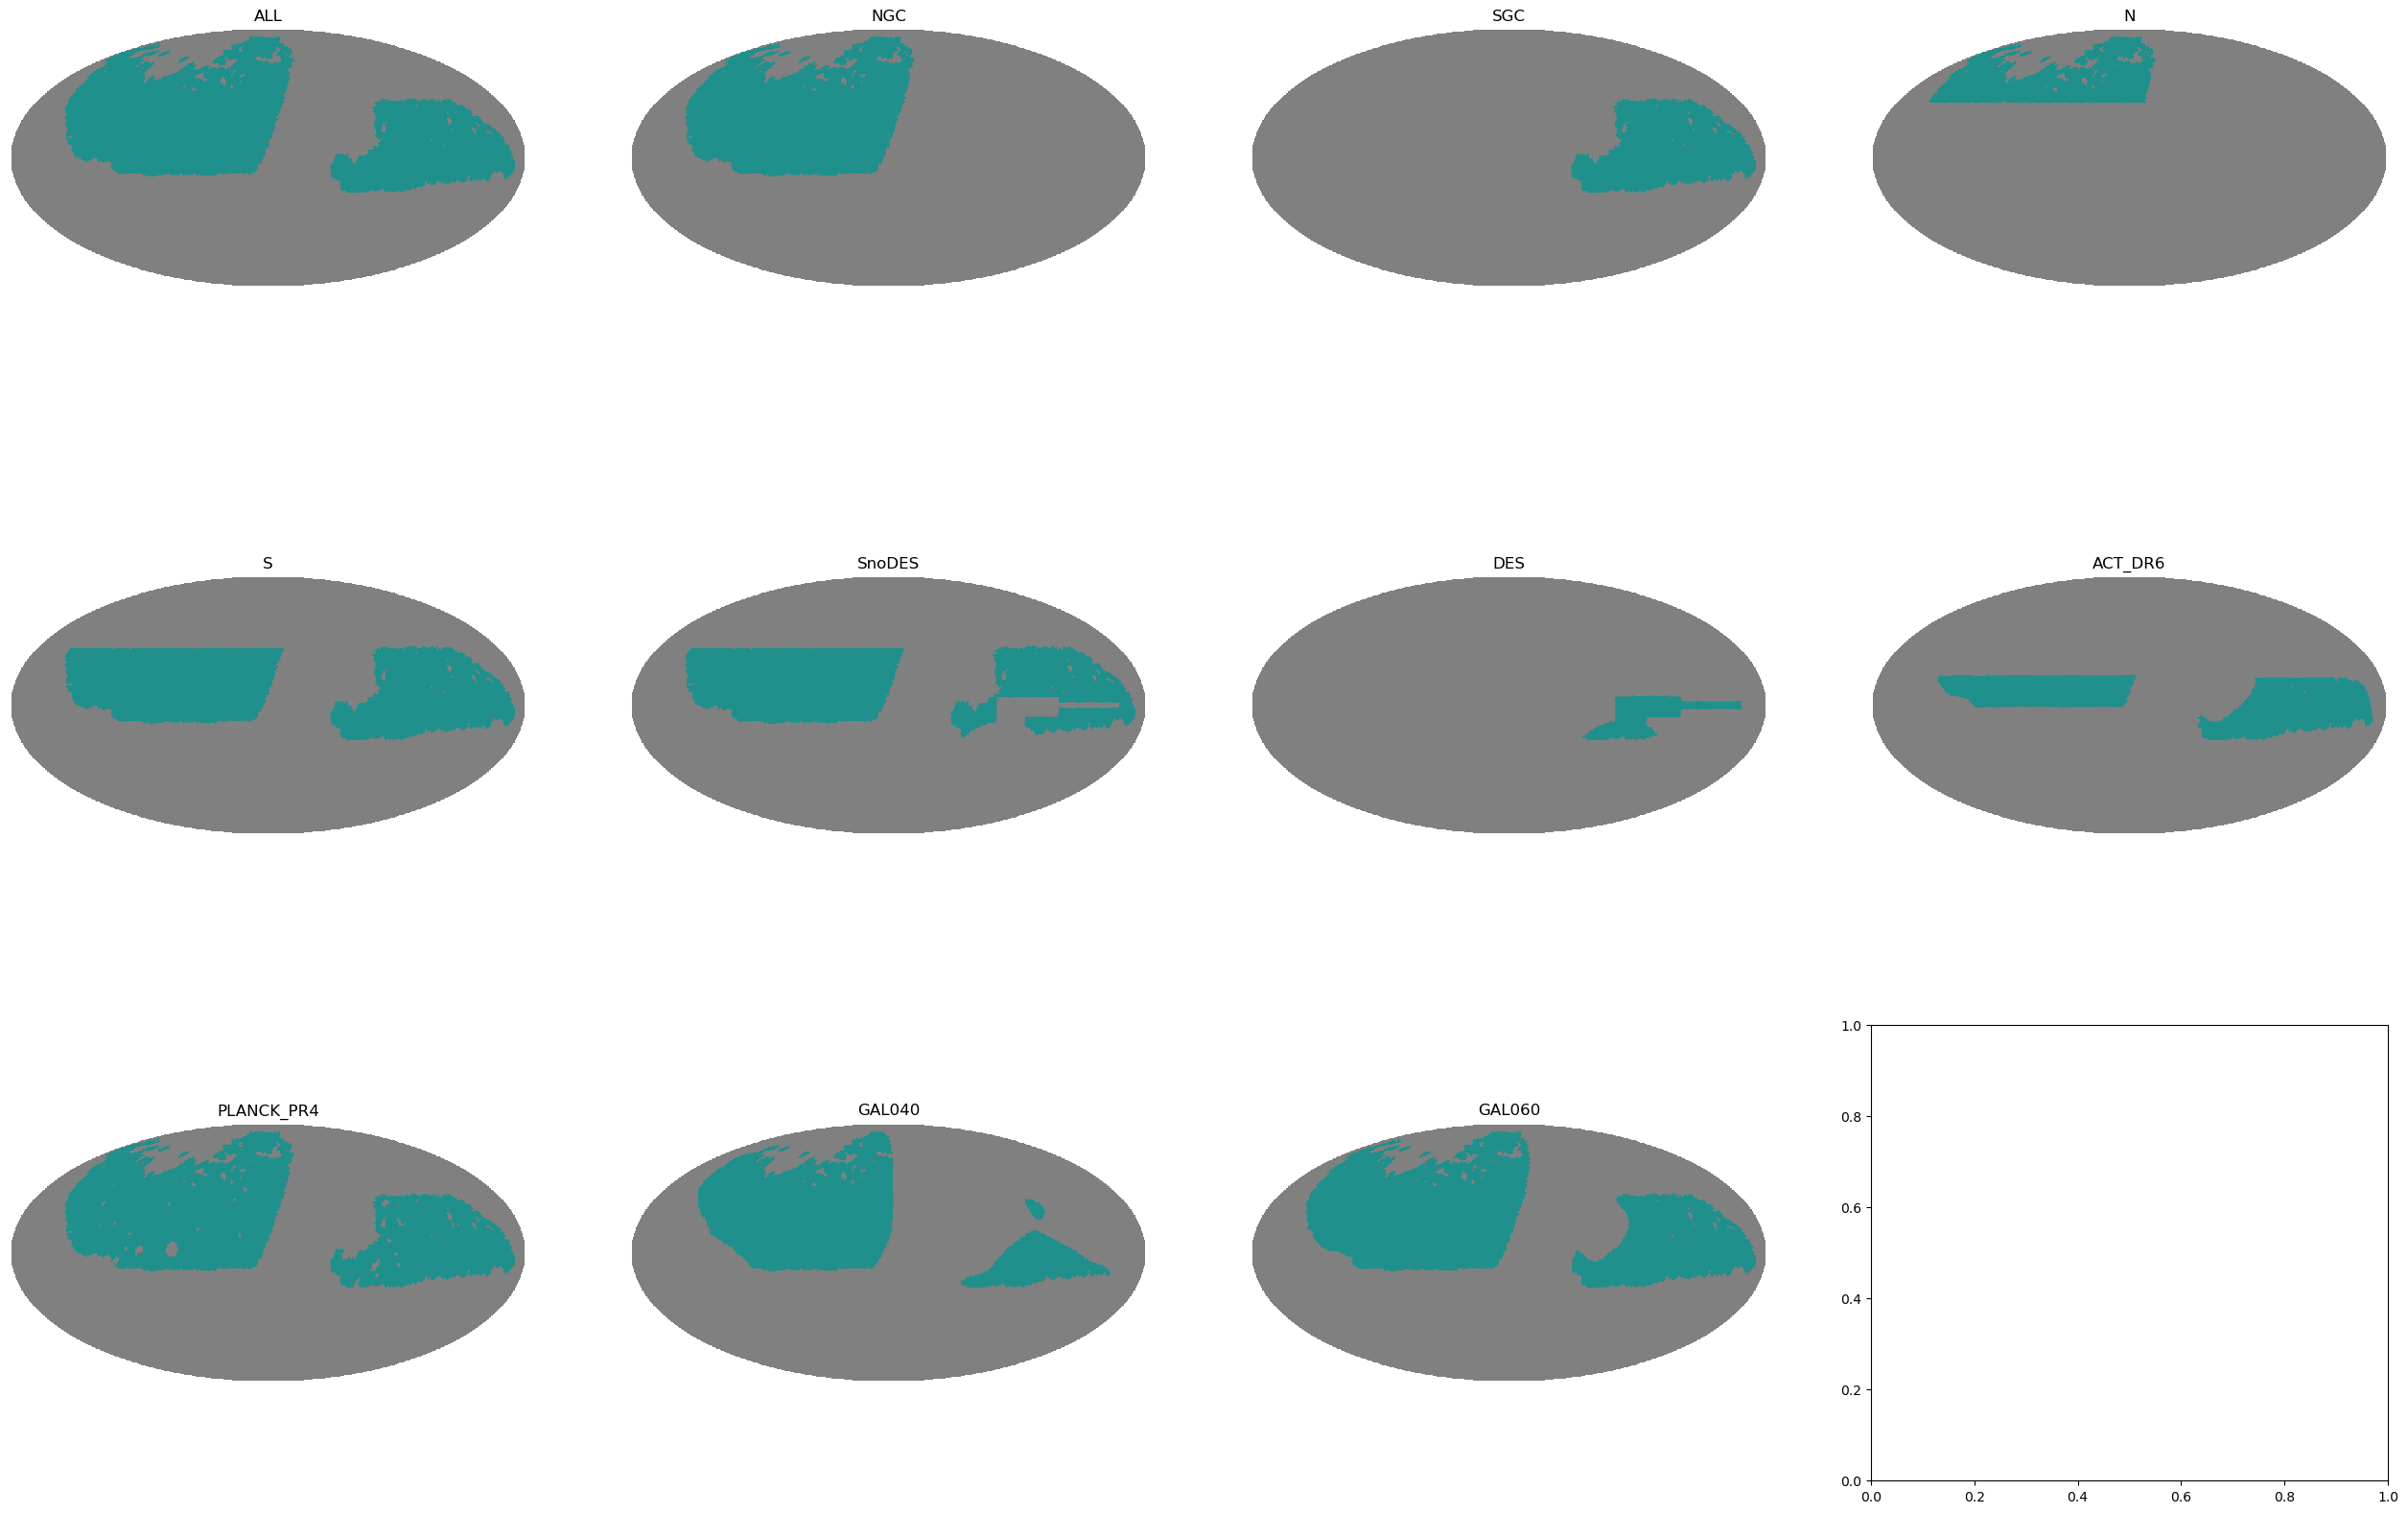

In [5]:
# check select_region function
regions = ['ALL','NGC','SGC','N','S','SnoDES','DES','ACT_DR6','PLANCK_PR4','GAL040','GAL060']

nplots = len(regions)
ncols = math.ceil(math.sqrt(nplots))
nrows = math.ceil(nplots / ncols)
fig, ax = plt.subplots(nrows,ncols,figsize=(8*ncols, 7*nrows),)
lax = ax.flatten()

# Region plots
for i, region in enumerate(regions):
    mask = select_region(ra, dec, region=region)
    plot_hpmap(nside, ra, dec,mask=mask, title=region,ax=lax[i])
plt.show()

[000048.44] [0/1] 02-20 01:39  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl201/loa-v1/mock201/LSScats/QSO_NGC_clustering.dat.h5.
[000048.45] [0/1] 02-20 01:39  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl201/loa-v1/mock201/LSScats/QSO_SGC_clustering.dat.h5.
[000048.52] [0/1] 02-20 01:39  tools                     INFO     Multiplying individual weights by WEIGHT_FKP
[000049.59] [0/1] 02-20 01:39  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl201/loa-v1/mock201/LSScats/QSO_NGC_clustering.dat.h5.
[000049.66] [0/1] 02-20 01:39  tools                     INFO     Multiplying individual weights by WEIGHT_FKP
[000050.22] [0/1] 02-20 01:39  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl201/loa-v1/mock201/LSScats/QSO_SGC_clustering.dat.h5.
[000050.25] [0/1] 02-2

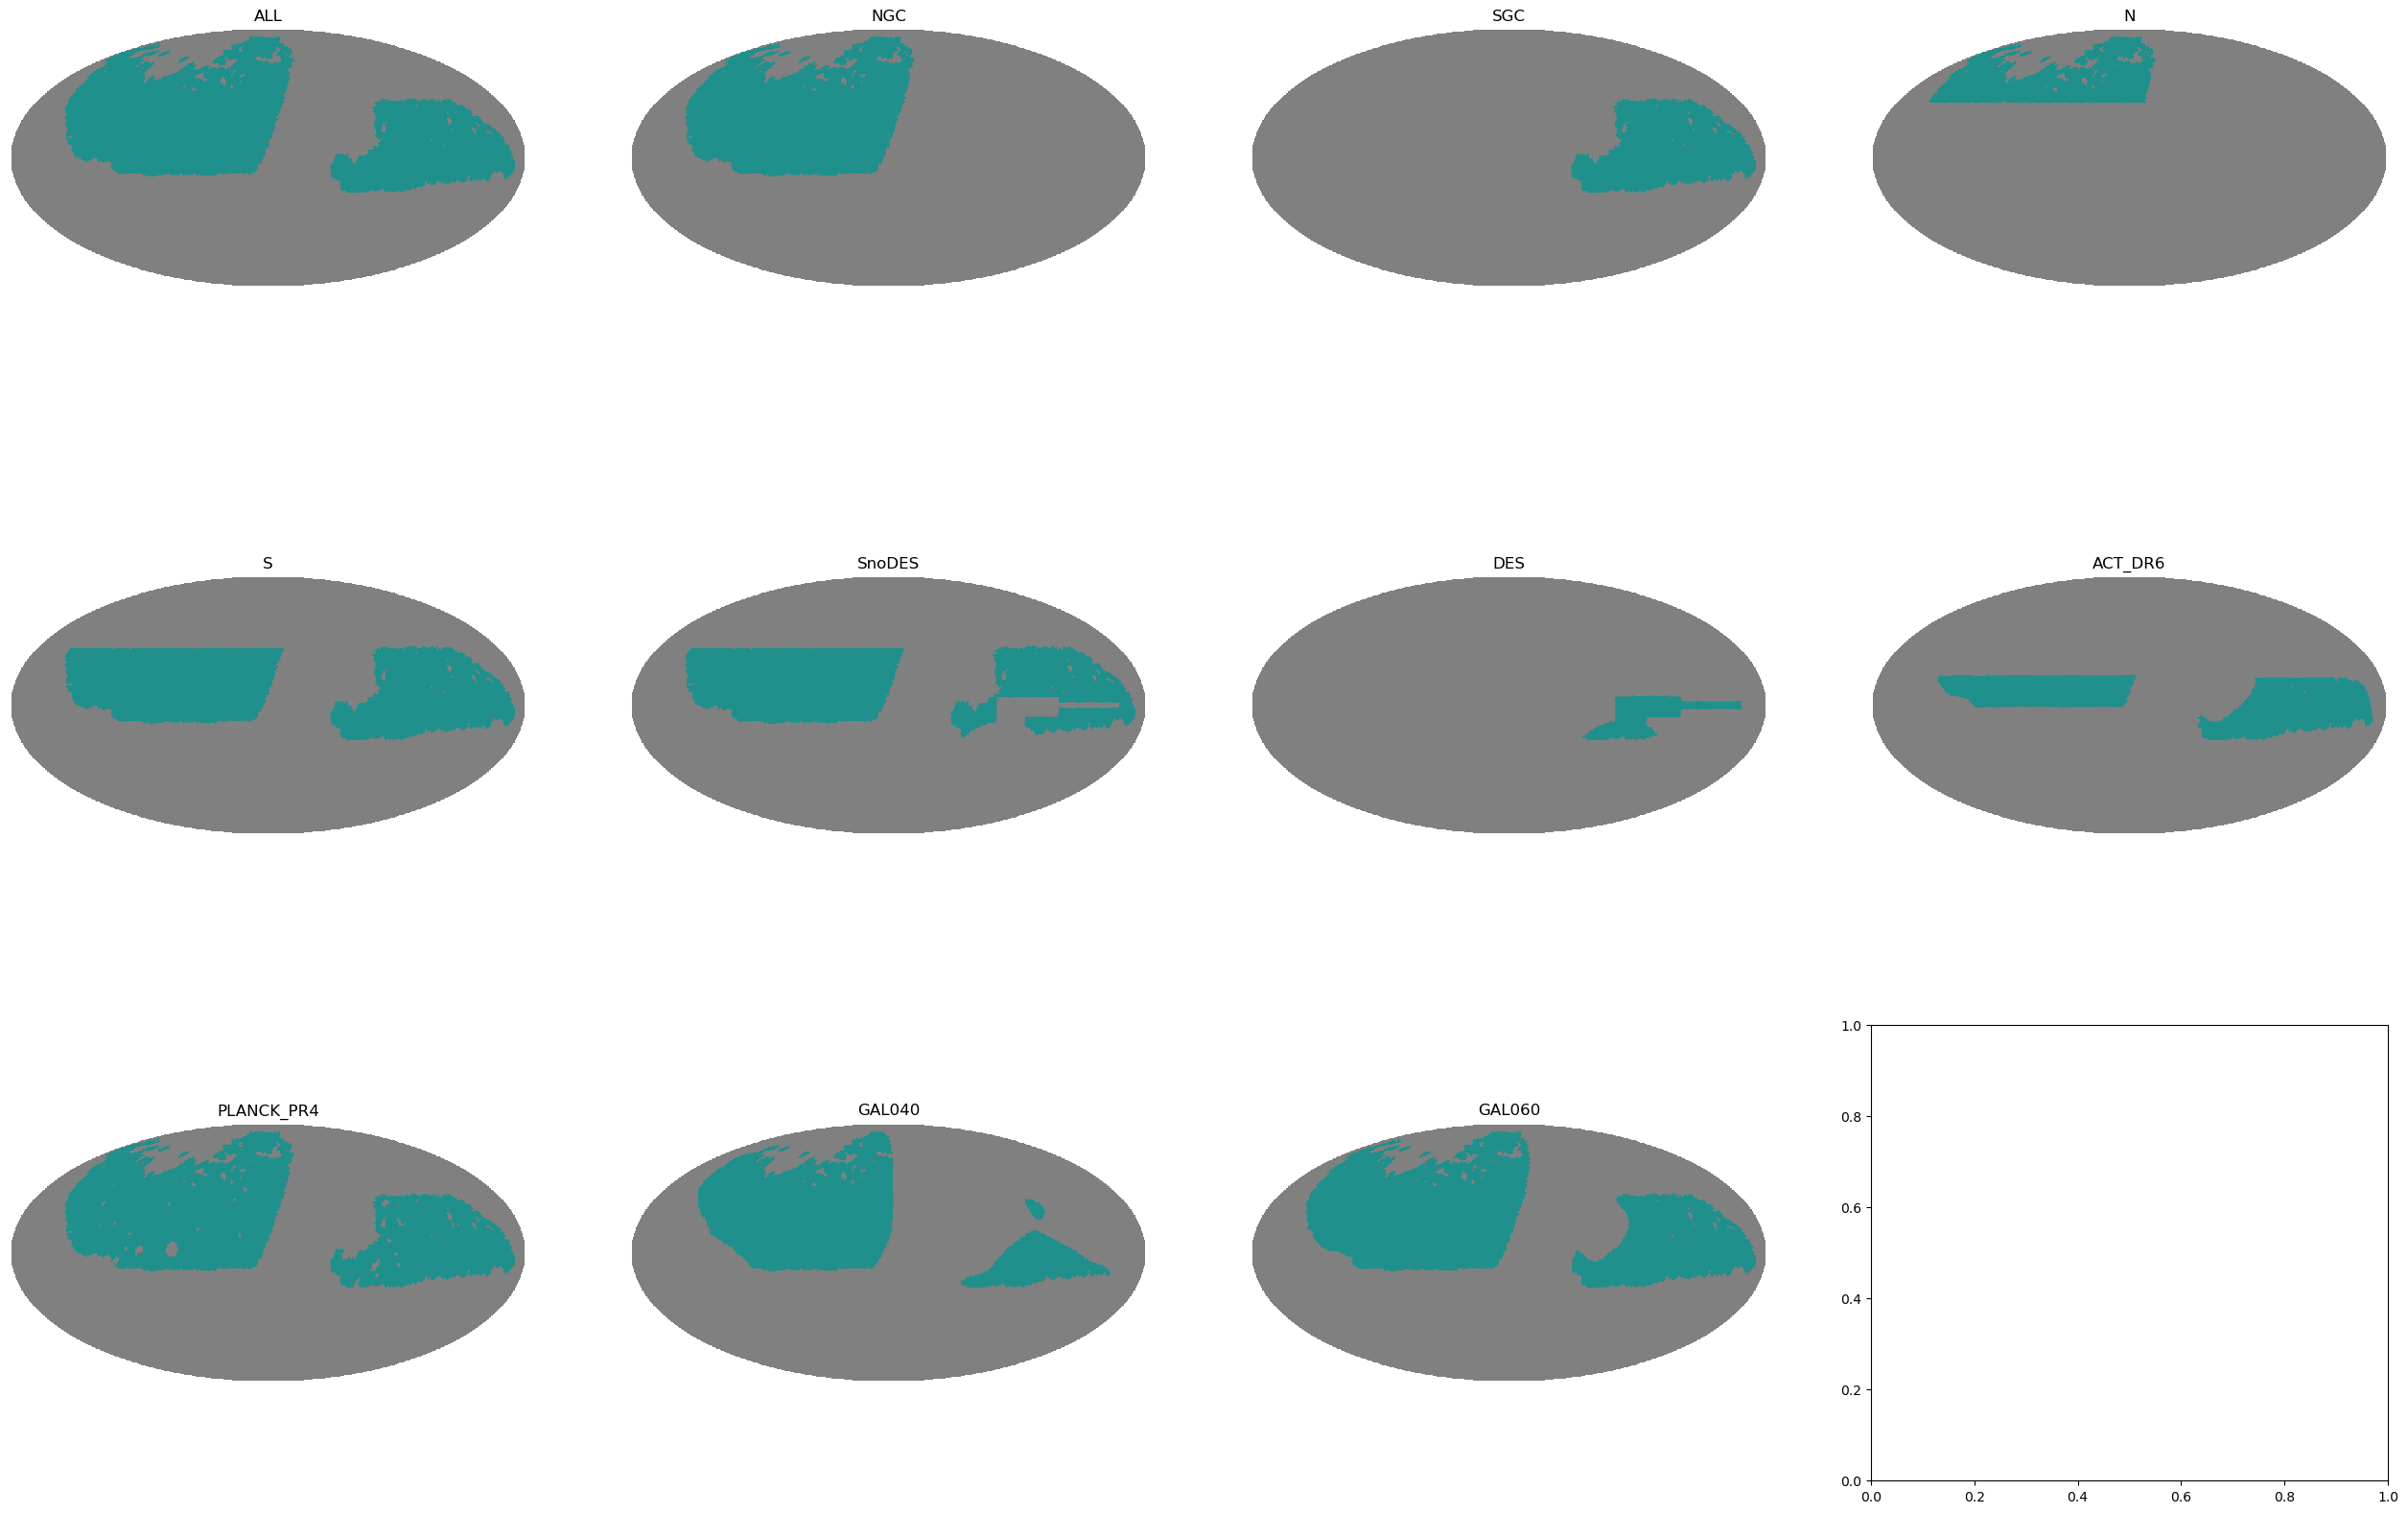

In [6]:
# check read_clustering_catalog behaves as expected given different regions
regions = ['ALL','NGC','SGC','N','S','SnoDES','DES','ACT_DR6','PLANCK_PR4','GAL040','GAL060']

nplots = len(regions)
ncols = math.ceil(math.sqrt(nplots))
nrows = math.ceil(nplots / ncols)
fig, ax = plt.subplots(nrows,ncols,figsize=(8*ncols, 7*nrows),)
lax = ax.flatten()

# Region plots
for i, region in enumerate(regions):
    data = read_clustering_catalog(kind='data', mpicomm=mpicomm, **(attrs|dict(region=region))) 
    ra,dec = data['RA'], data['DEC']
    plot_hpmap(nside, ra, dec,title=region,ax=lax[i])
plt.show()

In [7]:
help(select_region)

Help on function select_region in module clustering_statistics.tools:

select_region(ra, dec, region=None)
    Return mask of corresponding R.A./Dec. region.

    Parameters
    ----------
    ra : array_like
        R.A. coordinates in degrees.
    dec : array_like
        Dec. coordinates in degrees.
    region : str, optional
        Region to select. Options are:
        - None, 'ALL', 'GCcomb': all-sky
        - 'NGC': North Galactic Cap
        - 'SGC': South Galactic Cap
        - 'N': Northern region (Dec > 32.375 and in NGC)
        - 'S': Southern region (Dec > -25 and in SGC)
        - 'SNGC': Southern part of NGC
        - 'SSGC': Southern part of SGC
        - 'NGCnoN': NGC excluding Northern region
        - 'DES': DES footprint
        - 'SnoDES': Southern region excluding DES footprint
        - 'SSGCnoDES': Southern part of SGC excluding DES footprint
        - 'SGCnoDES': SGC excluding DES footprint
        - 'ACT_DR6': ACT DR6 footprint
        - 'PLANCK_PR4': Planck